In [2]:
import pandas as pd
import json


def read_jl_to_dataframe(path):
    with open(path) as f:
        lines = f.read().splitlines()

    df_inter = pd.DataFrame(lines)
    if df_inter.shape[0] == 0:
        return df_inter

    df_inter.columns = ["json_element"]
    df_inter["json_element"].apply(json.loads)
    df = pd.json_normalize(df_inter["json_element"].apply(json.loads))
    df = df.drop_duplicates(subset="id", keep="last").reset_index(drop=True)

    return df


In [3]:
df_tweets_tagged = read_jl_to_dataframe("../datasets/all_tagged.jl")
df_tweets_tagged.head()


,id,conversation_id,datetime,user_id,place,tweet,lang,replies_count,retweets_count,likes_count,retweet,near,geo,hashtags,place.type,place.coordinates,offensive
0,1471549573017608194,1471427657552343049,2021-12-16 19:35:32 Środkowoeuropejski czas st...,3301872724,,@karnkowski @Jaroslaw_Gowin miał szansę być an...,pl,0,0,1,False,,,[],None,None,1
1,1471435153817976834,1471237832199098375,2021-12-16 12:00:53 Środkowoeuropejski czas st...,938387588414607360,,"@GiertychRoman @Jaroslaw_Gowin , życzenia od M...",pl,0,0,0,False,,,[],None,None,0
2,1471238115931176970,1471178290429837316,2021-12-15 22:57:55 Środkowoeuropejski czas st...,1098620540338749440,,@Polina12180179 @Jakub_Banaszek Za mało za zdr...,pl,0,0,0,False,,,[],None,None,0
3,1471150229189799936,1471118304668532755,2021-12-15 17:08:41 Środkowoeuropejski czas st...,620191832,,@UrynowiczTomasz @Jaroslaw_Gowin @Wyborcza_Kra...,pl,0,0,1,False,,,[stopsegregacjisanitarnej],None,None,0
4,1471116644739133451,1470800759243489285,2021-12-15 14:55:14 Środkowoeuropejski czas st...,1137128289380773888,,@KOdowy @Mentasen @Hanna_Manowska @MZ_GOV_PL @...,pl,1,0,0,False,,,[],None,None,1


In [4]:
# add referenced party column

import pickle
import os
from os.path import exists

PATH = "../datasets/all_tagged_and_parties"
if exists(PATH):
    with open(PATH, "rb") as handle:
        df_tweets = pickle.load(handle)

else:
    i = 0
    for dirpath, dirnames, files in os.walk("../results"):
        for file_path in files:
            party = dirpath[11:]

            file_path = os.path.join(dirpath, file_path)
            if i == 0:
                df_tweets_party = read_jl_to_dataframe(file_path)
                df_tweets_party["party"] = party
            else:
                df_tweets = read_jl_to_dataframe(file_path)
                if df_tweets.shape[0] == 0:
                    continue
                df_tweets["party"] = party
                df_tweets_party = df_tweets_party.append(df_tweets)

            i += 1
    df_tweets_party = df_tweets_party.drop_duplicates(
        subset="id", keep="last"
    ).reset_index(drop=True)
    df_tweets_party = df_tweets_party.loc[:, ["id", "party"]]

    df_tweets = df_tweets_tagged.merge(df_tweets_party, on="id")
    with open(PATH, "wb") as handle:
        pickle.dump(df_tweets, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [5]:
df_tweets.head()


,id,conversation_id,datetime,user_id,place,tweet,lang,replies_count,retweets_count,likes_count,retweet,near,geo,hashtags,place.type,place.coordinates,offensive,party
0,1471549573017608194,1471427657552343049,2021-12-16 19:35:32 Środkowoeuropejski czas st...,3301872724,,@karnkowski @Jaroslaw_Gowin miał szansę być an...,pl,0,0,1,False,,,[],None,None,1,porozumienie
1,1471435153817976834,1471237832199098375,2021-12-16 12:00:53 Środkowoeuropejski czas st...,938387588414607360,,"@GiertychRoman @Jaroslaw_Gowin , życzenia od M...",pl,0,0,0,False,,,[],None,None,0,porozumienie
2,1471238115931176970,1471178290429837316,2021-12-15 22:57:55 Środkowoeuropejski czas st...,1098620540338749440,,@Polina12180179 @Jakub_Banaszek Za mało za zdr...,pl,0,0,0,False,,,[],None,None,0,porozumienie
3,1471150229189799936,1471118304668532755,2021-12-15 17:08:41 Środkowoeuropejski czas st...,620191832,,@UrynowiczTomasz @Jaroslaw_Gowin @Wyborcza_Kra...,pl,0,0,1,False,,,[stopsegregacjisanitarnej],None,None,0,porozumienie
4,1471116644739133451,1470800759243489285,2021-12-15 14:55:14 Środkowoeuropejski czas st...,1137128289380773888,,@KOdowy @Mentasen @Hanna_Manowska @MZ_GOV_PL @...,pl,1,0,0,False,,,[],None,None,1,porozumienie


In [6]:
posts_per_user = df_tweets.groupby(["user_id"]).size()
posts_per_user = posts_per_user.to_frame().reset_index().rename(columns={0: "all"})

df_tweets_hate = df_tweets[df_tweets["offensive"] == 1]
hate_per_user = df_tweets_hate.groupby(["user_id"]).size()
hate_per_user = hate_per_user.to_frame().reset_index().rename(columns={0: "hate"})

print(
    f"{100 * (hate_per_user.shape[0] / posts_per_user.shape[0]):.4}% badanych użytkowników co najmniej raz napisało post, zawierający mowę nienawiści"
)


61.58% badanych użytkowników co najmniej raz napisało post, zawierający mowę nienawiści


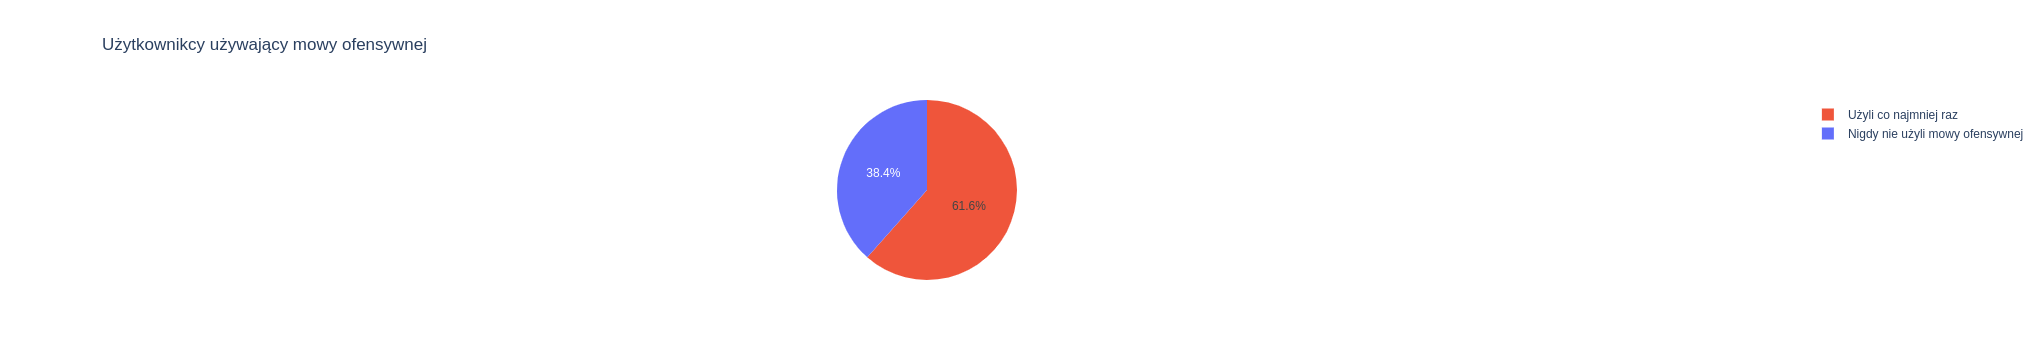

In [7]:
import plotly.express as px

data = {
    "Names": ["Nigdy nie użyli mowy ofensywnej", "Użyli co najmniej raz"],
    "Percentage": [
        1 - hate_per_user.shape[0] / (posts_per_user.shape[0]),
        hate_per_user.shape[0] / posts_per_user.shape[0],
    ],
}

df = pd.DataFrame(data)

fig = px.pie(
    df,
    values="Percentage",
    names="Names",
    title="Użytkownikcy używający mowy ofensywnej",
    color=df.index,
)

fig.show()


In [8]:
# add column (hate posts / all posts) for given user
posts_per_user = df_tweets.groupby(["user_id"]).size()
posts_per_user = posts_per_user.to_frame().reset_index().rename(columns={0: "all"})

df_tweets_hate = df_tweets[df_tweets["offensive"] == 1]
hate_per_user = df_tweets_hate.groupby(["user_id"]).size()
hate_per_user = hate_per_user.to_frame().reset_index().rename(columns={0: "hate"})

users_stats = posts_per_user.merge(hate_per_user, how="left", on="user_id")
users_stats.fillna(0, inplace=True)
users_stats["hate_coefficient"] = users_stats["hate"] / users_stats["all"]

print(users_stats.head())


   user_id  all  hate  hate_coefficient
0    23293    4   1.0          0.250000
1    59883    3   0.0          0.000000
2  1825191    1   0.0          0.000000
3  2539451    3   2.0          0.666667
4  2539791    2   0.0          0.000000


In [9]:
import numpy as np

print(users_stats["hate_coefficient"].quantile(np.arange(1, 0.0, -0.01)).to_string())

# 38 % - nigdy nie napisało nic ofensywnego
# 63 % - częściej pisze neutralne posty niż ofensywne
# 27 % - częściej pisze ofensywne posty niż neutralne
# 15 % - pisze tylko posty ofensywne


1.00    1.000000
0.99    1.000000
0.98    1.000000
0.97    1.000000
0.96    1.000000
0.95    1.000000
0.94    1.000000
0.93    1.000000
0.92    1.000000
0.91    1.000000
0.90    1.000000
0.89    1.000000
0.88    1.000000
0.87    1.000000
0.86    1.000000
0.85    1.000000
0.84    0.850894
0.83    0.777778
0.82    0.750000
0.81    0.705468
0.80    0.666667
0.79    0.666667
0.78    0.666667
0.77    0.625000
0.76    0.600000
0.75    0.582022
0.74    0.555556
0.73    0.523810
0.72    0.500000
0.71    0.500000
0.70    0.500000
0.69    0.500000
0.68    0.500000
0.67    0.500000
0.66    0.500000
0.65    0.500000
0.64    0.500000
0.63    0.454545
0.62    0.434783
0.61    0.416667
0.60    0.400000
0.59    0.397608
0.58    0.375000
0.57    0.351785
0.56    0.333333
0.55    0.333333
0.54    0.333333
0.53    0.333333
0.52    0.333333
0.51    0.300000
0.50    0.285714
0.49    0.250000
0.48    0.250000
0.47    0.250000
0.46    0.230769
0.45    0.204545
0.44    0.200000
0.43    0.181818
0.42    0.1666

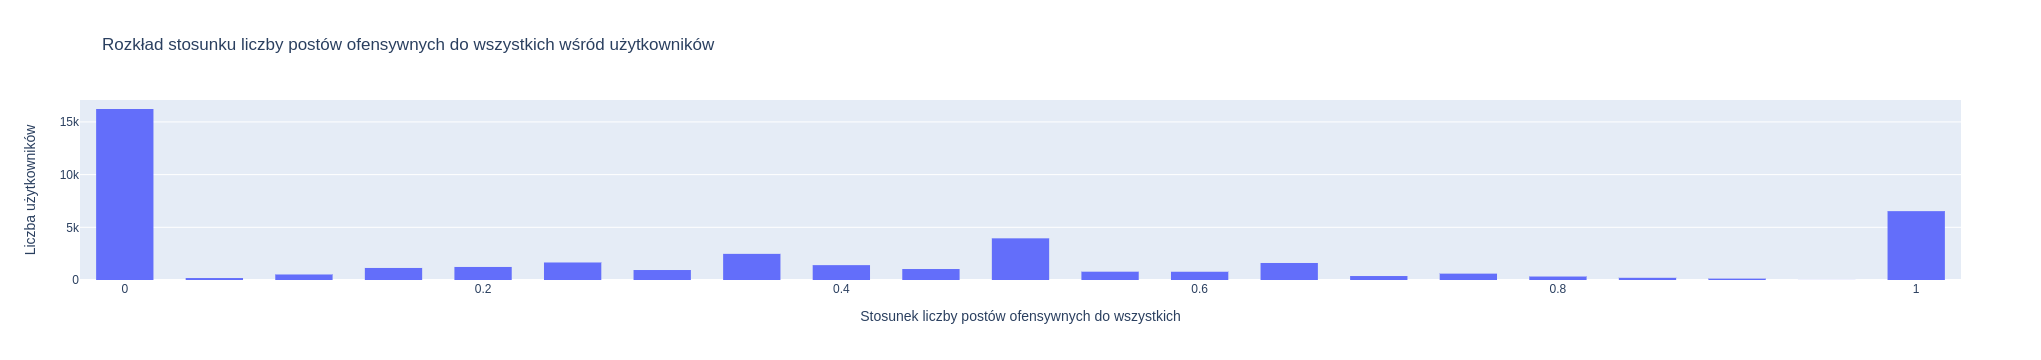

In [16]:
import plotly.graph_objects as go
import numpy as np

fig = go.Figure()
fig.add_trace(go.Histogram(
    x=users_stats["hate_coefficient"],
    name='control', # name used in legend and hover labels
    nbinsx = 50

))

fig.update_layout(
    title_text='Rozkład stosunku liczby postów ofensywnych do wszystkich wśród użytkowników', # title of plot
    xaxis_title_text='Stosunek liczby postów ofensywnych do wszystkich', # xaxis label
    yaxis_title_text='Liczba użytkowników', # yaxis label
    bargap=0.2, # gap between bars of adjacent location coordinates
    bargroupgap=0.2 # gap between bars of the same location coordinates
)

fig.show()

In [ ]:
# 10% hejterów kreuje prawie połowe hejtu

all_hates = df_tweets_hate.shape[0]
all_haters = hate_per_user.shape[0]

by = 0.9
hate_by_top10 = hate_per_user.sort_values("hate").iloc[int(all_haters * by):]['hate'].sum(axis=0)

print(f'{100*(1 - by):.4}% najbardziej ofensywnych osób kreuje {100 * (hate_by_top10/all_hates):.4}% mowy ofensywnej')

10.0% najbardziej ofensywnych osób kreuje 47.49% mowy ofensywnej
